In [1]:
from pathlib import Path
import sys
sys.path.append('..')
sys.path.append('../../datagen/')

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sensor_service as ss
import datagen as dg

plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 22})
random.seed(0)

pd.__version__

'1.4.2'

In [2]:
cfg = dg.config.Config.from_yaml(Path('../../configs/datagen.yaml'))
env = dg.types.Environment.from_config(cfg)
wts = dg.types.wind_turbines_from_config(env, Path('../../configs/map.yaml'))
sim = dg.types.Simulation(cfg, wts, env)
_ = sim.tick(100)

In [3]:
readings = []
sim.loop(readings.append, 1000, no_wait=True)

In [4]:
wtss = [{**wt, 'ticks': r['ticks']}
        for r in readings
        for wt in r['wts']]
df = pd.DataFrame(wtss)

In [5]:
df.head()

,wt_id,model_name,_faults,generator_temp,power,tower_vib_freq,rotor_rps,ticks
0,Turbine_001,AREVA-M5000-116,[],10.113004,4.420757e+06,4033.899745,662.422779,100
1,Turbine_002,AREVA-M5000-116,[],10.663081,3.946971e+06,4342.510385,617.171871,100
2,Turbine_003,AREVA-M5000-116,[],9.816681,3.944413e+06,4242.235925,608.381655,100
3,Turbine_004,AREVA-M5000-116,[],9.301567,4.229457e+06,4398.464158,650.370651,100
4,Turbine_005,AREVA-M5000-116,[],9.922994,4.003637e+06,4085.879312,595.553675,100


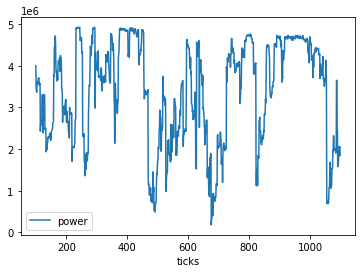

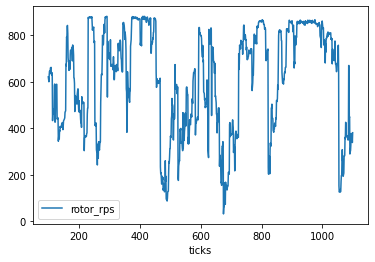

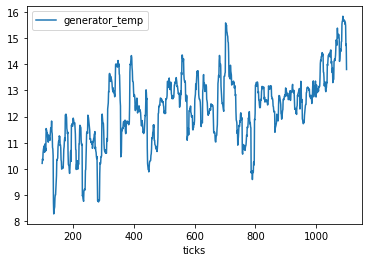

In [6]:
COLS = ['rotor_rps', 'power', 'generator_temp']
df_tick = df.groupby('ticks')
cols = df_tick[COLS]
means = cols.mean()
means.power.plot()
plt.legend()
plt.show()
means.rotor_rps.plot()
plt.legend()
plt.show()
means.generator_temp.plot()
plt.legend()
plt.show()

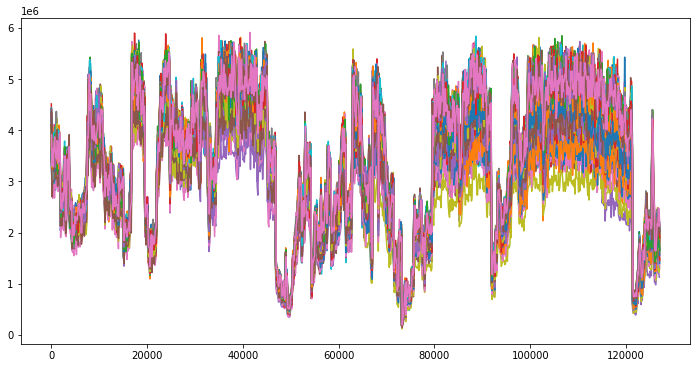

In [7]:
plt.figure(figsize=(12, 6))
wts = df.groupby('wt_id').power.plot()
plt.show()

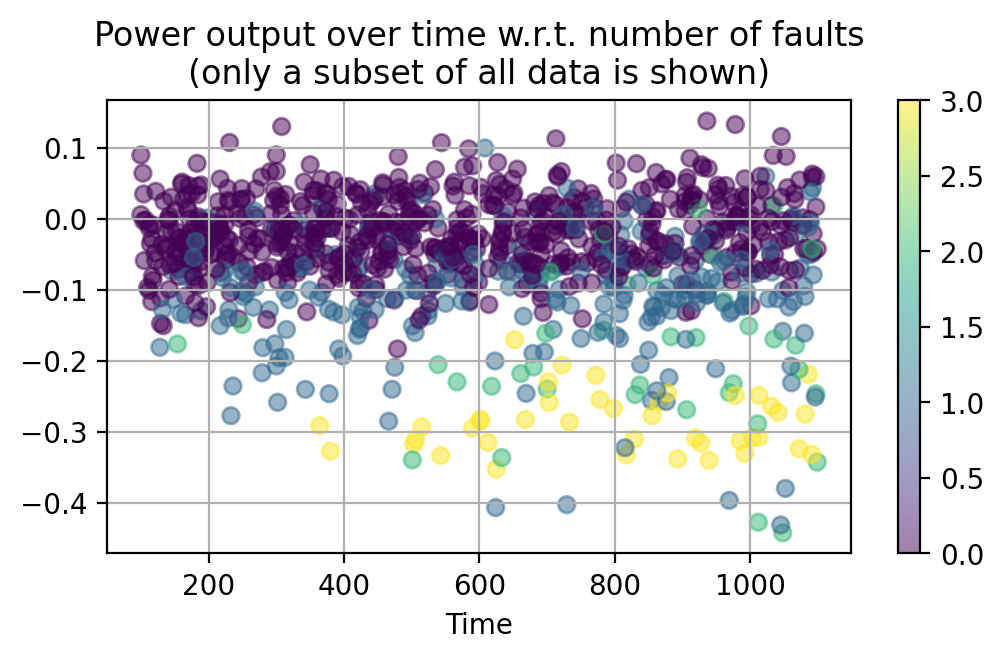

In [8]:
TOLERANCE = 1.5
QUANTILE = 0.75

df_tick = df.groupby('ticks')
cols = df_tick[COLS]
avg = cols.quantile(QUANTILE)
dfm = df.merge(avg, how='left', on='ticks', suffixes=('', '_avg'))
dfm['dev'] = (dfm['power'] - dfm['power_avg']) / dfm['power_avg']
dfm['nfaults'] = dfm._faults.map(len)

dfms = dfm.sample(1000)

plt.figure(figsize=(6, 3), dpi=200)
plt.title('Power output over time w.r.t. number of faults\n(only a subset of all data is shown)')
plt.scatter(dfms.ticks, dfms.dev, alpha=0.5, c=dfms.nfaults)
plt.grid()
plt.xlabel('Deviation from the 75th percentile')
plt.xlabel('Time')
plt.colorbar()
plt.show()

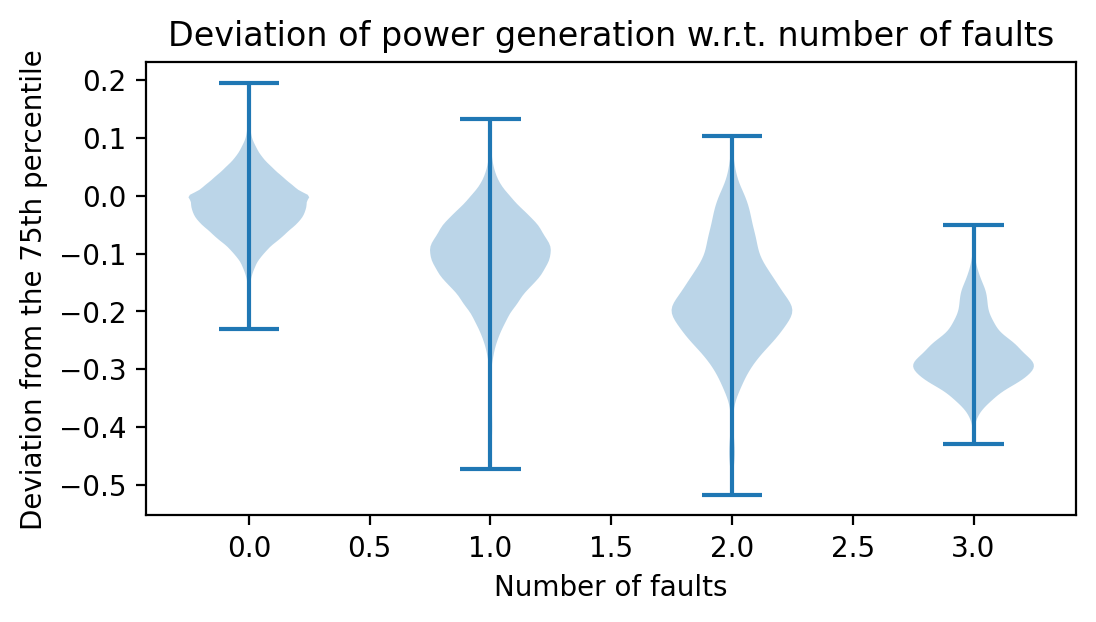

In [16]:
#wts = dfm[dfm.ticks == 1000]
plt.figure(figsize=(6, 3), dpi=200)
plt.violinplot([x.dev for _, x in dfm.groupby('nfaults') if len(x) > 1], positions=[0, 1, 2, 3])
plt.ylabel('Deviation from the 75th percentile')
plt.xlabel('Number of faults')
plt.title('Deviation of power generation w.r.t. number of faults')
plt.show()

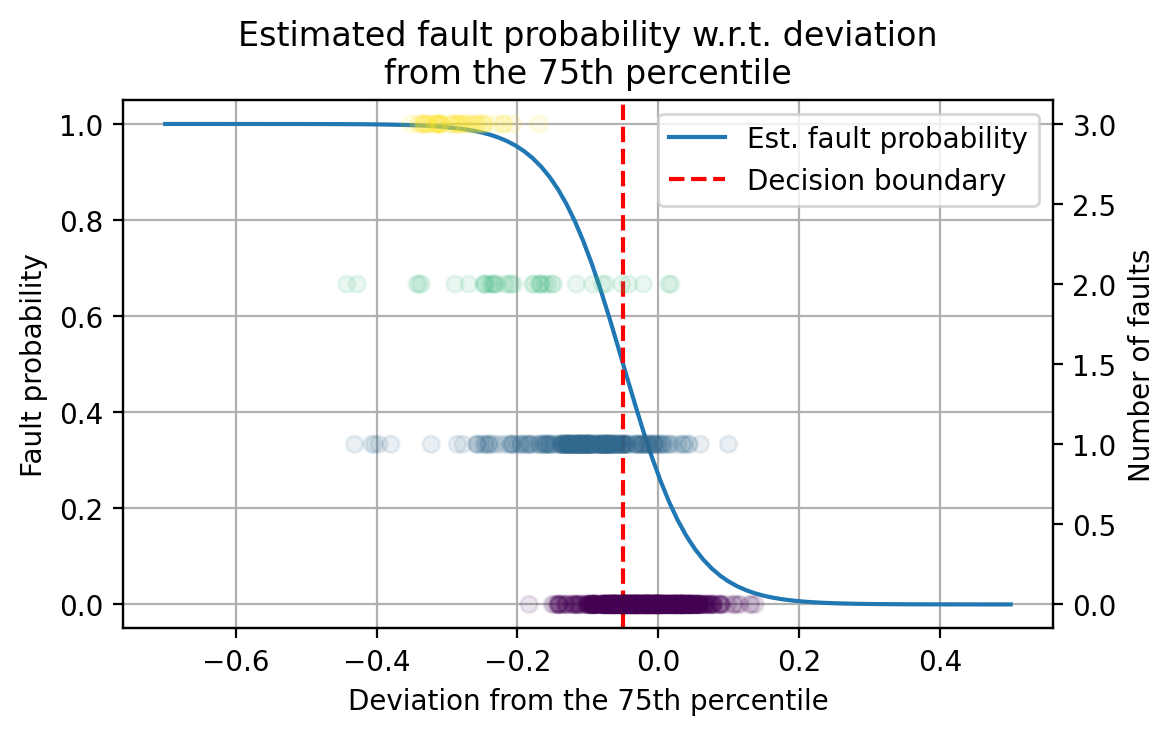

In [10]:
THRESHOLD = -0.05
WIDTH = 0.05

sigmoid = lambda x: 1 / (1 + np.exp((x - THRESHOLD) / WIDTH))

xs = np.linspace(-0.7, 0.5, num=100)
ys = sigmoid(xs)

fig, ax1 = plt.subplots(figsize=(6, 3.5), dpi=200)

ax1.set_ylabel('Fault probability')
ax1.set_xlabel('Deviation from the 75th percentile')
ax1.plot(xs, ys, label='Est. fault probability')

ax2 = ax1.twinx()
ax2.set_ylabel('Number of faults')
ax2.scatter(dfms.dev, dfms.nfaults, alpha=0.1, c=dfms.nfaults)

ax1.axvline(THRESHOLD, color='red', linestyle='--', label='Decision boundary')

ax1.legend()
ax1.set_title('Estimated fault probability w.r.t. deviation\nfrom the 75th percentile')

ax1.grid()
plt.show()

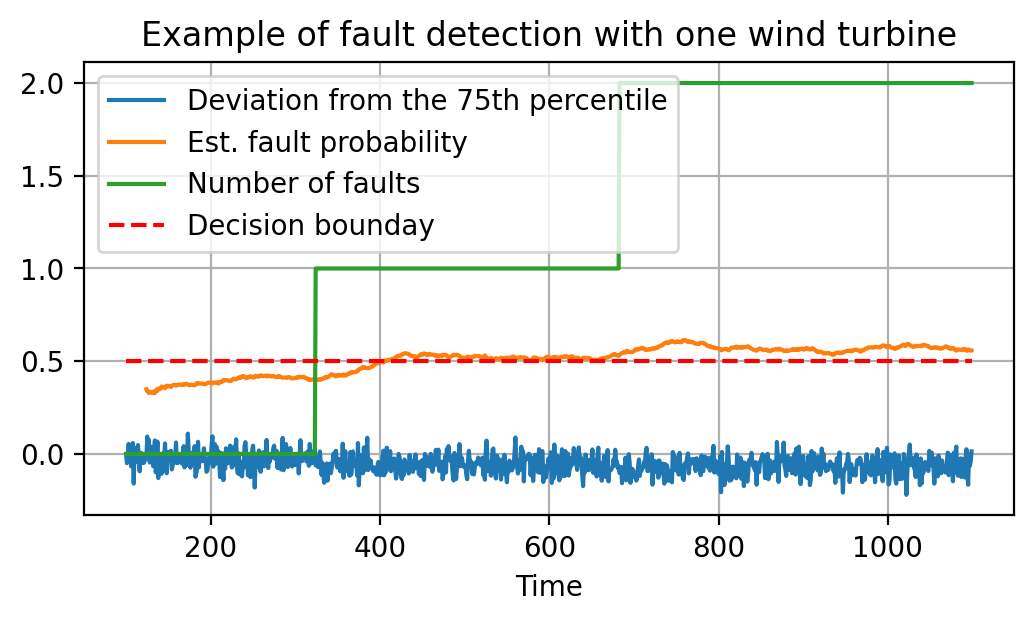

In [14]:
dfm['fprob'] = sigmoid(dfm.dev)

smoothed = (dfm
            .groupby('wt_id')
            .fprob
            # See: https://github.com/pandas-dev/pandas/issues/38523
            .apply(lambda x: x.rolling(100, min_periods=25).mean())
           )

dfx = dfm.merge(smoothed, right_index=True, left_index=True, suffixes=('', '_avg'))

#wt = dfx[dfm.wt_id == 'Turbine_017']
wt = dfx[dfm.wt_id == 'Turbine_017']

#wt = wt.rolling(10).mean()

plt.figure(figsize=(6, 3), dpi=200)
plt.plot(wt.ticks, wt.dev, label='Deviation from the 75th percentile')
plt.plot(wt.ticks, wt.fprob_avg, label='Est. fault probability')
plt.plot(wt.ticks, wt.nfaults, label='Number of faults')
plt.hlines(0.5, min(wt.ticks), max(wt.ticks), linestyle='--', label='Decision bounday', color='red')

plt.xlabel('Time')
plt.title('Example of fault detection with one wind turbine')

plt.legend()

plt.grid()

In [12]:
dfx

,wt_id,model_name,_faults,generator_temp,power,tower_vib_freq,rotor_rps,ticks,rotor_rps_avg,power_avg,generator_temp_avg,dev,nfaults,fprob,fprob_avg
0,Turbine_001,AREVA-M5000-116,[],10.113004,4.420757e+06,4033.899745,662.422779,100,647.178276,4.143081e+06,10.494260,0.067022,0,0.087829,NaN
1,Turbine_002,AREVA-M5000-116,[],10.663081,3.946971e+06,4342.510385,617.171871,100,647.178276,4.143081e+06,10.494260,-0.047334,0,0.486675,NaN
2,Turbine_003,AREVA-M5000-116,[],9.816681,3.944413e+06,4242.235925,608.381655,100,647.178276,4.143081e+06,10.494260,-0.047952,0,0.489760,NaN
3,Turbine_004,AREVA-M5000-116,[],9.301567,4.229457e+06,4398.464158,650.370651,100,647.178276,4.143081e+06,10.494260,0.020848,0,0.195138,NaN
4,Turbine_005,AREVA-M5000-116,[],9.922994,4.003637e+06,4085.879312,595.553675,100,647.178276,4.143081e+06,10.494260,-0.033657,0,0.419005,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126995,Turbine_123,AREVA-M5000-116,[GeneratorDamage[power_factor=0.85574]],13.840464,1.651677e+06,4398.316305,381.411761,1099,403.942763,2.019083e+06,14.051361,-0.181967,1,0.933351,0.449592
126996,Turbine_124,AREVA-M5000-116,[],13.984502,1.894443e+06,4767.905374,415.386493,1099,403.942763,2.019083e+06,14.051361,-0.061731,0,0.558388,0.341690
126997,Turbine_125,AREVA-M5000-116,[],14.216008,2.042400e+06,4128.247527,388.072852,1099,403.942763,2.019083e+06,14.051361,0.011548,0,0.226014,0.327106
126998,Turbine_126,AREVA-M5000-116,[],14.239127,2.015427e+06,4446.098245,388.593108,1099,403.942763,2.019083e+06,14.051361,-0.001811,0,0.276121,0.329071
